### Lectura de la imagen e inicializacion de variables

8392704


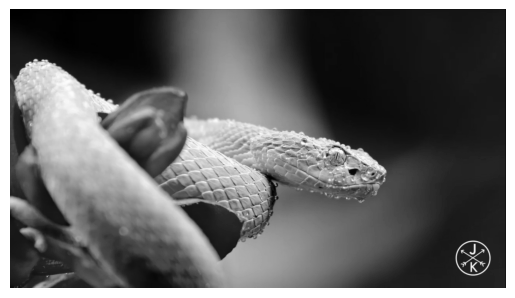

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import math
from scipy import signal
from skimage.color import rgb2gray


qpsk = np.array([1+1j, -1+1j, 1-1j, -1-1j]) / np.sqrt(2)

qam16 = np.array([-3-3j, -3-1j, -3+3j, -3+1j,  
                          -1-3j, -1-1j, -1+3j, -1+1j,  
                           3-3j,  3-1j,  3+3j,  3+1j,  
                           1-3j,  1-1j,  1+3j,  1+1j]) / np.sqrt(10)

qam64 = np.array([-7-7j, -7-5j, -7-3j, -7-1j, -7+7j, -7+5j, -7+3j, -7+1j,
                          -5-7j, -5-5j, -5-3j, -5-1j, -5+7j, -5+5j, -5+3j, -5+1j,
                          -3-7j, -3-5j, -3-3j, -3-1j, -3+7j, -3+5j, -3+3j, -3+1j,
                          -1-7j, -1-5j, -1-3j, -1-1j, -1+7j, -1+5j, -1+3j, -1+1j,
                           7-7j,  7-5j,  7-3j,  7-1j,  7+7j,  7+5j,  7+3j,  7+1j,
                           5-7j,  5-5j,  5-3j,  5-1j,  5+7j,  5+5j,  5+3j,  5+1j,
                           3-7j,  3-5j,  3-3j,  3-1j,  3+7j,  3+5j,  3+3j,  3+1j,
                           1-7j,  1-5j,  1-3j,  1-1j,  1+7j,  1+5j,  1+3j,  1+1j]) / np.sqrt(42)

#Parámetros 
Modulacion = 'QPSK' #Modulacion
BW = 10 #Ancho de banda en MHz
Referencia = 4+4j
# Leer la imagen
imagena = mpimg.imread("Frame1.jpg")
imagen = rgb2gray(imagena)*255
datos_array = np.array(imagen, dtype=np.uint8)
datos = np.unpackbits(datos_array.flatten())

# Mostrar el número total de bits
# Mostrar la imagen original
print(len(datos))
plt.imshow(datos_array,cmap='gray')
plt.axis('off')
plt.show()

### Modulacion QPSK, 16-QAM, 64-QAM

In [ ]:
def generarSimbolos(datos, modulacion):
    longitud = len(datos)
    
    if modulacion == 'QPSK':
        # 2 bits por símbolo
        datos = np.array(datos).reshape(-1, 2)
        indices = datos.dot(1 << np.arange(2)[::-1])  # Mapea los bits a índices
        simbolos = qpsk[indices]

    elif modulacion == '16-QAM':
        # 4 bits por símbolo
        datos = np.array(datos).reshape(-1, 4)
        indices = datos.dot(1 << np.arange(4)[::-1])  # Mapea los bits a índices
        simbolos = qam16[indices]

    elif modulacion == '64-QAM':
        # 6 bits por símbolo
        datos = np.array(datos).reshape(-1, 6)
        indices = datos.dot(1 << np.arange(6)[::-1])  # Mapea los bits a índices
        simbolos = qam64[indices]

    else: 
        raise Exception('Solo de QPSK a 64QAM.')
    
    return simbolos

nBloques = math.ceil(BW/0.18)
nSubportadoras = nBloques * 12
modulado = generarSimbolos(datos,Modulacion)
#print(len(modulado))
for i in range(6,nSubportadoras,12):
    modulado = np.insert(modulado, i, Referencia)

nSimbolos = len(modulado)
nSimbolosOFDM = math.ceil(nSimbolos/nSubportadoras)
print('Número de bloques de recursos:',nBloques)
print('Número de subportadoras:',nSubportadoras)
print('Número de símbolos a enviar:',nSimbolos)
print('Número de símbolos OFDM:',nSimbolosOFDM)

Número de bloques de recursos: 56
Número de subportadoras: 672
Número de símbolos a enviar: 4196408
Número de símbolos OFDM: 6245


### Modulacion OFDM

In [ ]:
N = 2**math.ceil(math.log2(nSubportadoras))
print(N)


datosOFDM = np.zeros(nSimbolosOFDM * N, np.complex64)  # Array para almacenar los símbolos OFDM, inicializado con ceros y de tipo complejo
j = 0  # Índice para los datos de entrada
k = 0  # Índice para los datos OFDM


for i in range(nSimbolosOFDM):
    scArray = np.zeros(N, np.complex64)
    if i == (nSimbolosOFDM-1):
        longitud=len(modulado[j:j+nSubportadoras])
        if longitud < nSubportadoras:
            scArray[0:nSubportadoras] = np.concatenate((modulado[j:j+nSubportadoras],np.zeros(nSubportadoras-longitud)))
        else:
            scArray[0:nSubportadoras] = modulado[j:j+nSubportadoras]
    else:
        scArray[0:nSubportadoras] = modulado[j:j+nSubportadoras]
    # Realizar la modulación IFFT
    datosOFDMsr = np.fft.ifft(scArray, N)  # Aplicar IFFT para convertir los datos al dominio del tiempo
    datosOFDM[k:k + N] = datosOFDMsr
    # Incrementar los índices
    j = j + nSubportadoras  # Incrementar el índice para los datos de entrada
    k = k + N  # Incrementar el índice para los datos OFDM




1024


### Prefijo cíclico

In [87]:
# Define la función para agregar el prefijo cíclico (CP)
def anadirPrefijo(simboloOfdm, N, longitudCP):
    # Extraer el CP (las últimas longitudCP muestras del símbolo OFDM)
    cp = simboloOfdm[N - longitudCP:N:1]
    
    # Concatenar el CP y el símbolo OFDM
    simboloOfdm_cp = np.concatenate((cp, simboloOfdm))
    
    return simboloOfdm_cp

def calculate_papr(signal):
    peak_power = np.max(np.abs(signal)**2)
    avg_power = np.mean(np.abs(signal)**2)
    papr = 10 * np.log10(peak_power / avg_power)  # En dB
    return papr

longitudCP = math.ceil((N/66.666666)*4.7)
#longitudCP = 0

# Agregar el CP a cada uno de los símbolos OFDM
ofdmConCP = np.zeros(nSimbolosOFDM * (N + longitudCP), np.complex64)  # Inicializar un array para los datos OFDM con CP
j = 0
k = 0
Papr = []
for i in range(nSimbolosOFDM):
    # Llamar a la función anadirPrefijo para agregar el CP al símbolo OFDM y almacenarlo en el array ofdmConCP
    ofdmConCP[k:(k + N + longitudCP)] = anadirPrefijo(datosOFDM[j:j + N], N, longitudCP)
    #Papr.append(calculate_papr(ofdmConCP[k:(k + N + longitudCP)]))
    
    # Incrementar los índices para la siguiente iteración
    j = j + N
    k = k + N + longitudCP


#plt.figure(figsize=(15, 4))
#plt.plot(Papr,'b')
#plt.title('PAPR de los símbolos enviados')
#plt.xlabel('Símbolo')
#plt.ylabel('Magnitud')
#plt.show()


### Efectos del canal

In [ ]:
# Parámetros del canal de multicamino

nCaminos = 5
h = np.random.randn(nCaminos) + np.random.randn(nCaminos)*1j
# Aplicar filtro del canal 
canal = np.fft.fft(h,N)

Senal_mp = np.convolve(ofdmConCP,h)[int((nCaminos-1)/2):-math.ceil((nCaminos-1)/2)]

#Efecto de canal AWGN
SNR = 20 # Desired SNR (dB) 
def awgn(senal,SNR):
    # Measure signal power 
    potenciaSenal = np.mean(abs(senal)**2)

    # Calculate noise power 
    potenciaRuido = potenciaSenal/(10 **(SNR/10))
    
    # Generate complex noise 
    noise = np.sqrt(potenciaRuido/2)*(np.random.randn(len(senal)) + np.random.randn(len(senal))*1j)
    
    # Add signal and noise 
    senalRuidosa = senal + noise 
    
    return senalRuidosa 
SenalRx = awgn(Senal_mp,SNR)
#SenalRx = Senal_mp
#SenalRx = ofdmConCP
len(SenalRx)

6850765

### Demodulacion OFDM

4196352
1024
4196352


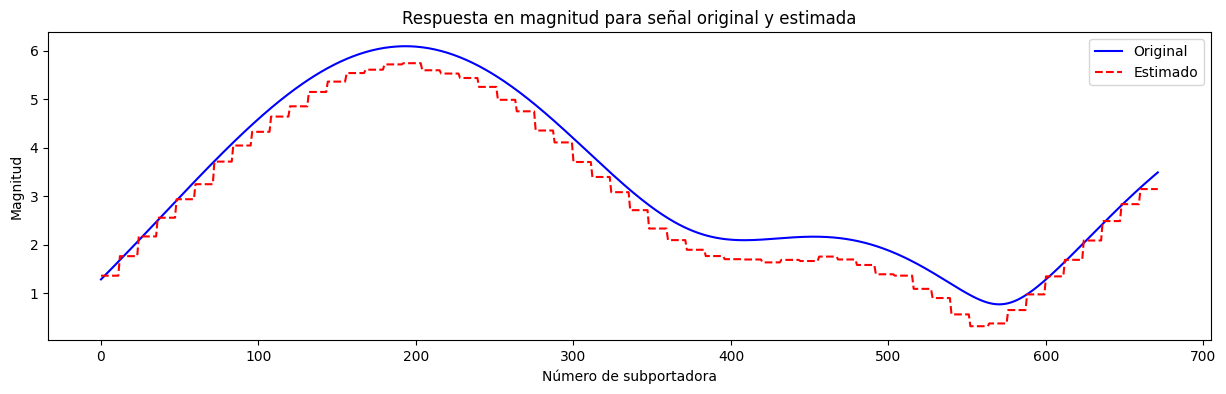

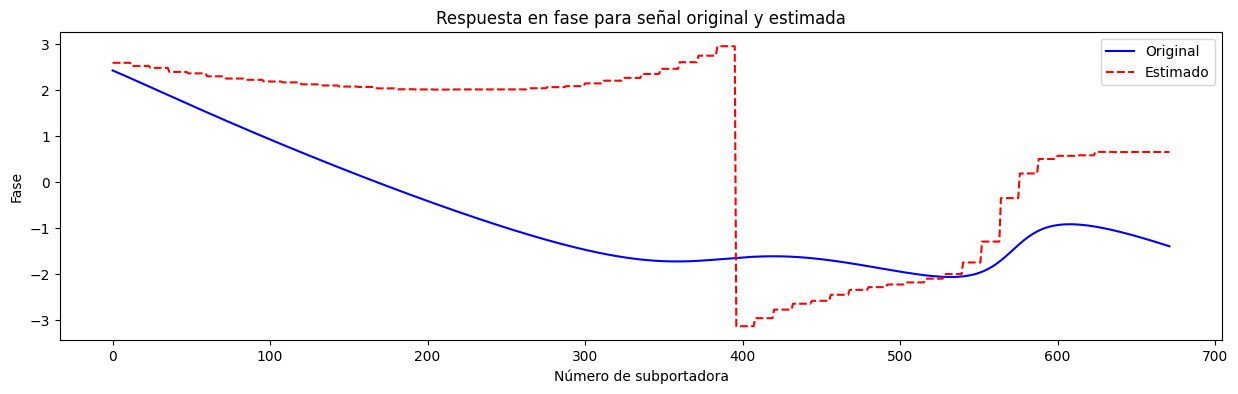

In [ ]:
def demodulacionOFDM(ofdmRx, N, longitudCP):
    # Remover el CP (Prefijo Cíclico) de los símbolos OFDM recibidos
    ofdmSinPrefijo = ofdmRx[longitudCP:(N + longitudCP)]
    
    # Realizar la Transformada Rápida de Fourier (FFT) sobre los símbolos OFDM sin CP
    # fftshift se utiliza para centrar la frecuencia 0 en el centro del espectro
    data = np.fft.fft(ofdmSinPrefijo, N)
    return data

# Array para almacenar los símbolos de datos recuperados
rxDatos = np.zeros(nSimbolos-nBloques, np.complex64)
estimado_rx = []
j = 0
k = 0 
x = 0
# Extraer el contenido de datos (después del final del L-LTF)
L = len(SenalRx)
print(len(rxDatos))
Referencias_rx = []
# Demodular los símbolos OFDM en el contenido de datos
for i in range(nSimbolosOFDM):
    rx_demod = demodulacionOFDM(SenalRx[k:(k + N + longitudCP)], N, longitudCP)
    if i == 0:
        for l in range(len(rx_demod)):
            if l%12 == 6:
                if l <= nSubportadoras:
                    Referencias_rx.append(rx_demod[l])
                x += 1
            else:
                rxDatos[l-x]=rx_demod[l]
        print(len(rx_demod))
        j = j + nSubportadoras - nBloques
        for l in range(nSubportadoras):
            estimado_rx.append(Referencias_rx[l//12])
        estimacion_canal = np.array(estimado_rx)/(Referencia)
    else:
        if i == (nSimbolosOFDM-1):
            rxDatos[j:j + nSubportadoras] = rx_demod[0:(len(rxDatos)-j)]/estimacion_canal[0:(len(rxDatos)-j)]
        else:
            rxDatos[j:j + nSubportadoras] = rx_demod[0:nSubportadoras]/estimacion_canal
    
    # Actualizar los índices para la siguiente iteración
        j = j + nSubportadoras
    k = k + N + longitudCP
print(len(rxDatos))
# Respuesta en magnitud
plt.figure(figsize=(15, 4))
plt.plot(abs(canal)[0:nSubportadoras],'b')
plt.plot(abs(estimacion_canal),'--r')
plt.title('Respuesta en magnitud para señal original y estimada')
plt.xlabel('Número de subportadora')
plt.ylabel('Magnitud')
plt.legend(('Original','Estimado'))
plt.show()
# Respuesta en fase
plt.figure(figsize=(15, 4))
plt.plot(np.angle(canal)[0:nSubportadoras],'b')
plt.plot(np.angle(estimacion_canal),'--r')
plt.title('Respuesta en fase para señal original y estimada')
plt.xlabel('Número de subportadora')
plt.ylabel('Fase')
plt.legend(('Original','Estimado'))
plt.show()



### Demodulacion QPSK, 16-QAM, 64-QAM

In [ ]:
constelaciones = {
    'QPSK': qpsk,
    '16-QAM': qam16,
    '64-QAM': qam64
}


def decision_vectorizada(modulado, matriz):
    # Calcular todas las distancias en una sola operación vectorizada
    distancias = np.abs(modulado[:, np.newaxis] - matriz)  # Broadcasting para calcular distancias
    indices = np.argmin(distancias, axis=1)  # Encuentra los índices de las distancias mínimas
    # Convertir los índices a binario de forma vectorizada
    bits = np.array([list(np.binary_repr(i, width=int(np.log2(len(matriz))))) for i in indices], dtype=int)
    return bits.flatten()  # Devolver como un solo vector plano

if Modulacion not in constelaciones:
    raise Exception('Modulation method must be QPSK, 16-QAM, or 64-QAM.')

# Selección de la constelación de acuerdo al tipo de modulación
constelacion = constelaciones[Modulacion]

# Aplicar la función de decisión a todos los valores modulados de una vez
dataSombrero = decision_vectorizada(rxDatos, constelacion)
print(len(rxDatos))


4196352


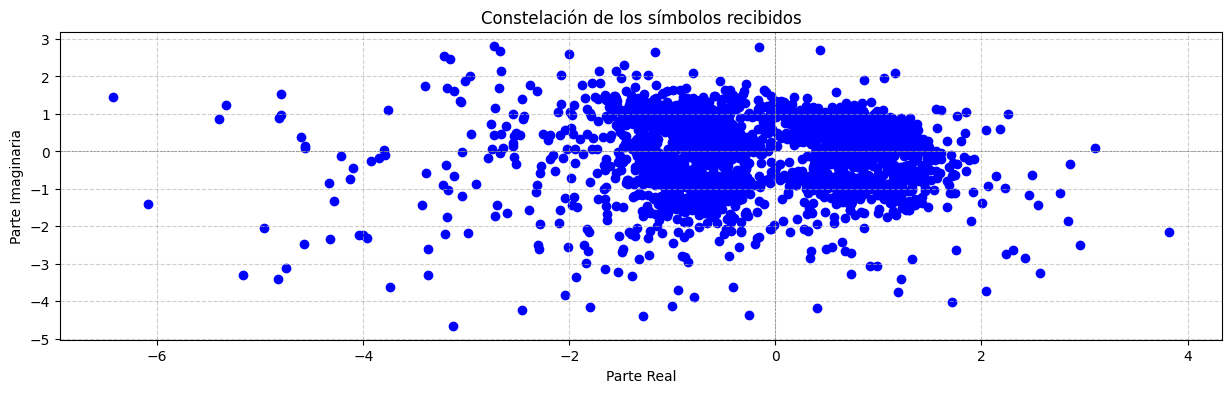

In [91]:
grafica = rxDatos[5000:10000]

plt.figure(figsize=(15, 4))  # Cuadrar para que sea proporcional
plt.scatter(grafica.real, grafica.imag, color='blue')
plt.axhline(0, color='gray', linestyle='--', linewidth=0.5)
plt.axvline(0, color='gray', linestyle='--', linewidth=0.5)
plt.title('Constelación de los símbolos recibidos')
plt.xlabel('Parte Real')
plt.ylabel('Parte Imaginaria')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

### Calculo del BER

In [92]:
def calcular_BER(bits_reales, bits_recibidos):
    if len(bits_reales) != len(bits_recibidos):
        raise ValueError("Los vectores deben tener la misma longitud.")
    
    # Calcular el número de bits en error
    errores = np.sum(bits_reales != bits_recibidos)
    
    # Calcular la Tasa de Error de Bit (BER)
    ber = errores / len(bits_reales)
    return ber

#print(len(datos))
#print(len(dataSombrero))
print("BER:",calcular_BER(datos,dataSombrero))

BER: 0.016458104563201563


### Imagen recibida

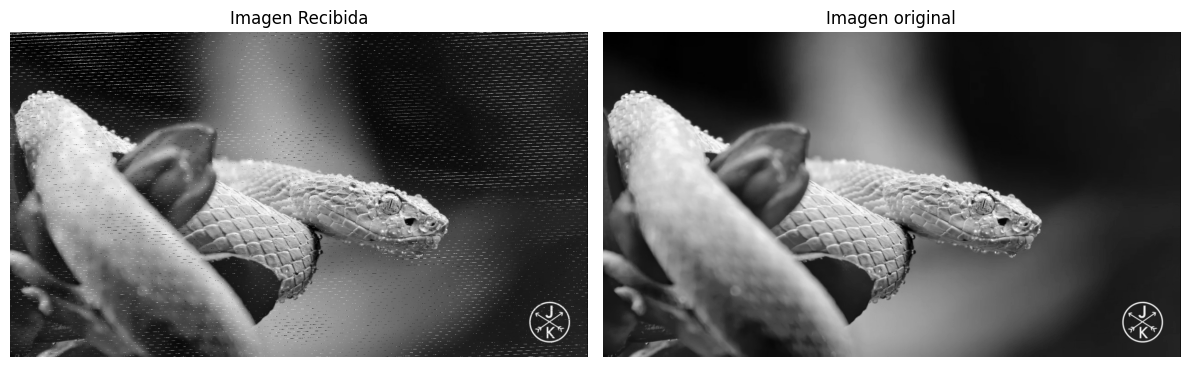

In [93]:
#Grafica recibida
datos_rx = dataSombrero

bits_array = np.array(datos_rx, dtype=np.uint8)
num_bytes = bits_array.size // 8  # Cantidad de bytes necesarios
bytes_array = bits_array[:num_bytes * 8].reshape(-1, 8)

# Convertir los grupos de 8 bits en valores enteros de 0 a 255 (uint8)
pixels_array = np.packbits(bytes_array)

# Reconstruir la imagen a partir de los píxeles
# Primero, debemos saber la forma original de la imagen
dimension_original = (768, 1366)  # Asegúrate de usar las dimensiones correctas
imagen_recuperada = pixels_array.reshape(dimension_original)

# Mostrar la imagen recuperada
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Gráfica 1
axes[0].imshow(imagen_recuperada, cmap='gray')
axes[0].axis('off')
axes[0].set_title('Imagen Recibida')

# Gráfica 2
axes[1].imshow(datos_array, cmap='gray')
axes[1].axis('off')
axes[1].set_title('Imagen original')

# Mostrar ambas gráficas
plt.tight_layout()
plt.show()

